## Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

### 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонт прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3

### 2. Оцените ошибку модели из п.1 .

### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor

функция: Экспоненциальное сглаживание

In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

функция: Добавление истории на глубину `p` (создание `p` новых признаков)

In [3]:
def feature_engeniring(series, p=3):
    
    df= pd.DataFrame(series)
    
    # добавили историю на глубину p измерения от текущего
    for i in range(1, p+1):
        df[f't{i}'] = 0
        df.iloc[i:,i]=df.iloc[:-i,0].values

    df.fillna(0)
    
    # добавили сглаживание (3 вида - просто для коллекции)
    df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
    df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
    df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
    
    # добавим разности - 1-й порядок
    df['diff1'] = 0
    df['diff1'].iloc[1:] = df.iloc[1:,0].values-df.iloc[:-1,0].values
    
    return df

функция: Разделение данных на тренирововчную и тестовую выборки

In [4]:
def split_data(df, split_date):
    return df.loc[df.index <= split_date].copy(), \
           df.loc[df.index >  split_date].copy()

функция: Разделение данных на `X_train`, `y_train`, `X_test`, `y_test` для горизонта прогноза `h`

In [5]:
def split_h(df, split_date, h=1):
    
    train, test = split_data( df, split_date)
    
    X_train = train.iloc[:-h,:]
    y_train = train[df.columns[0]].values[h:]
    X_test  = test.iloc[:-h,:]
    y_test  = test[df.columns[0]].values[h:]
    
    return X_train, y_train, X_test, y_test

функция: Оценка точности модели

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Читаем датасет

In [7]:
Path_Energy = 'PJME_hourly.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


Ресемплинг по дням

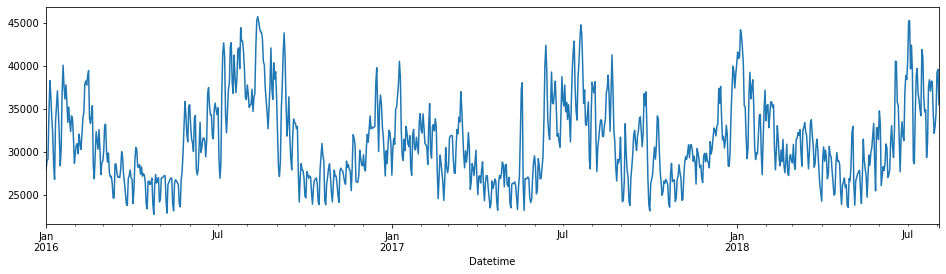

In [8]:
data = data.resample('D').mean()

plt.figure(figsize = (16,4))
data.loc['2016':,'PJME_MW'].plot()

Применяем экспоненциальное сглаживание

In [9]:
data_s = exponential_smoothing(data['PJME_MW'],0.1)
data_s = pd.Series(data_s, index=data.index)

Посмотрим, что насглаживали

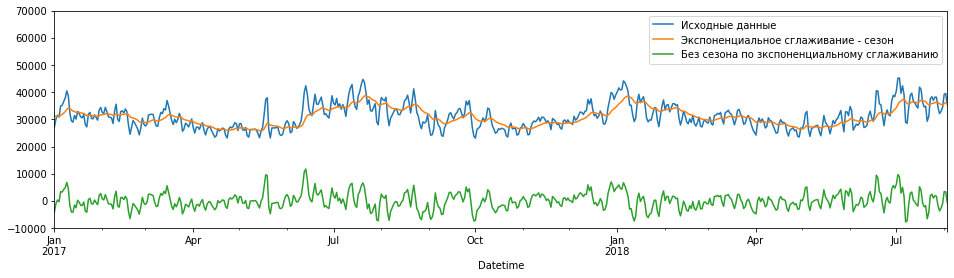

In [10]:
plt.figure(figsize = (16,4))

data.loc['2017':,'PJME_MW'].plot(label='Исходные данные')

data_s['2017':].plot(label='Экспоненциальное сглаживание - сезон')

dif_scince_2017 = data.loc['2017':,'PJME_MW'] - data_s['2017':]
dif_scince_2017.plot(label='Без сезона по зкспоненциальному сглаживанию')

plt.legend(loc='upper right')
plt.ylim(-10000,70000)
plt.show()

Тест стационарности по Дики-Фуллеру

In [11]:
DF = sm.tsa.stattools.adfuller(dif_scince_2017 , regression = 'ctt')
print(f'p-value: {DF[1]}')

p-value: 0.00010351795304819199


p-value показывает, что можно с достаточной увереностью принять разность исходного и сглаженного рядов как стационарный ряд.

Сконструируем новые признаки для реализации глубины истории `p=3`

In [12]:
data_p = feature_engeniring(data_s, p=3)
data_p.head()

,0,t1,t2,t3,exp_0_01,exp_0_03,exp_0_08,diff1
Datetime,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000
2002-01-02,31398.819384,31080.739130,0.000000,0.000000,31083.919933,31090.281538,31106.185551,318.080254
2002-01-03,31710.124946,31398.819384,31080.739130,0.000000,31090.181983,31108.876840,31154.500702,311.305562
2002-01-04,31910.658284,31710.124946,31398.819384,31080.739130,31098.386746,31132.930284,31214.993309,200.533339
2002-01-05,31760.104956,31910.658284,31710.124946,31398.819384,31105.003928,31151.745524,31258.602241,-150.553328


#### Разделим данные на тренировочные и тестовые для предсказаний с горизнтом прогноза `h=1`

In [13]:
split_date = '01-01-2017'

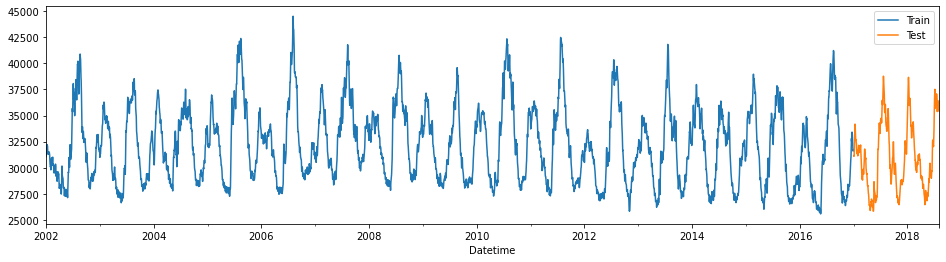

In [14]:
X_train_1, y_train_1, X_test_1, y_test_1 = split_h(data_p, split_date, h=1)

plt.figure(figsize = (16,4))
X_train_1[0].plot(label='Train')
X_test_1[0].plot(label='Test')
plt.legend()
plt.show()

Обучим модель градиентного бустинга и выполним предсказание

In [15]:
model_1 = GradientBoostingRegressor(max_depth=2, random_state=0, n_estimators=1500)
model_1.fit( X_train_1, y_train_1 ) 
y_test_1_pred = model_1.predict(X_test_1)

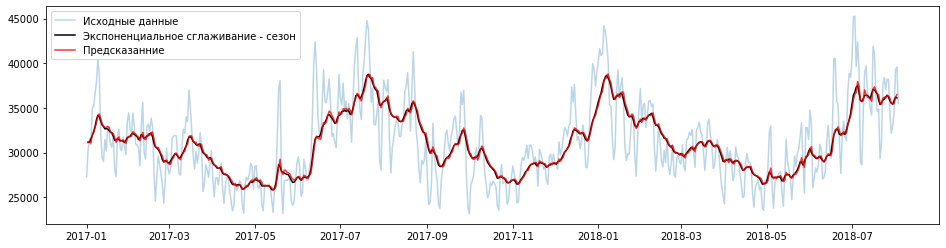

In [16]:
plt.figure(figsize = (16,4))
plt.plot(data.loc[split_date:,'PJME_MW'], label='Исходные данные', alpha=0.3)
plt.plot(X_test_1.index, y_test_1, label='Экспоненциальное сглаживание - сезон', c='black')
plt.plot(X_test_1.index, y_test_1_pred, label='Предсказанние',c='r',alpha=0.8)
plt.legend()
plt.show()

In [17]:
er_g = mean_absolute_percentage_error(y_true=y_test_1, y_pred=y_test_1_pred)
print('Ошибка предсказания сезонной части на горизонте прогноза 1 :  ', er_g, '%')

Ошибка предсказания сезонной части на горизонте прогноза 1 :   0.6318538816808144 %


#### Разделим данные на тренировочные и тестовые для предсказаний с горизнтом прогноза `h=10`

In [18]:
X_train_10, y_train_10, X_test_10, y_test_10 = split_h(data_p, split_date, h=10)

Обучим модель градиентного бустинга и выполним предсказание

In [19]:
model_10 = GradientBoostingRegressor(max_depth=2, random_state=0, n_estimators=1500)
model_10.fit( X_train_10, y_train_10 ) 
y_test_10_pred = model_10.predict(X_test_10)

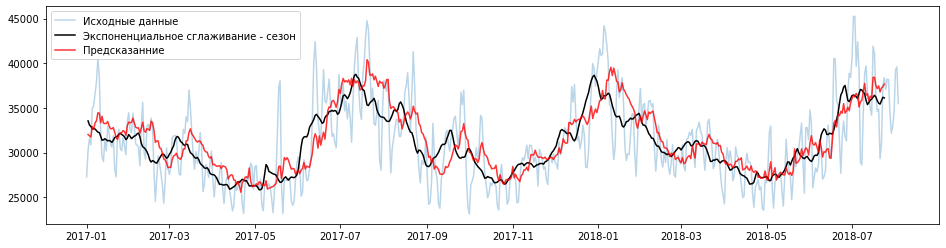

In [20]:
plt.figure(figsize = (16,4))
plt.plot(data.loc[split_date:,'PJME_MW'], label='Исходные данные', alpha=0.3)
plt.plot(X_test_10.index, y_test_10, label='Экспоненциальное сглаживание - сезон',c='black')
plt.plot(X_test_10.index, y_test_10_pred, label='Предсказанние',c='r',alpha=0.8)
plt.legend()
plt.show()

In [21]:
er_g = mean_absolute_percentage_error(y_true=y_test_10, y_pred=y_test_10_pred)
print('Ошибка предсказания сезонной части на горизонте прогноза 10 :  ', er_g, '%')

Ошибка предсказания сезонной части на горизонте прогноза 10 :   4.671106435429204 %


#### Вывод: С увеличением горизонта прогноза, ошибка предсказания возрасла с 0.63% (h=1) до 4.67% (h=10)

### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени
    


а) Изменение температуры за окном - нестацонарный ряд. Имеет сезонные составляющие по временам года, по времени суток. 
Возможно имеет циклические составляющие, зависящие от разных факторов, например, существуют ледниковые периоды, сейчас в наше время - климатический оптимум. Если расматривать послденее столетие, то есть тренд - глобальное потепление из-за парникового эффекта, вызванного антропогенным воздействием.

б) Количество денег, которые тратят покупатели в интернет магазине. Нестационарный ряд. Сезонность - днем и ночью разные траты. Цикличность - может быть есть связь с экономическими кризисами. Тренд вызванный инфляцией, цены растут - растут и траты.

в) Вес растущего котенка. Нестационарный, имеет тренд. Если кот уличный, то, возможно, есть сезонная составляющая, за зиму худеет, за лето - толстеет.

г) Прирост объема деревьев в лесу от времени. Может быть стационарным, новые деревья растут, старые падают и сгнивают.

## 5. Какие из рядов на картинке стационарны на первый взгляд? (презентация, слайд номер 21)
#### b и d